# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import re
import nltk
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# load data from database
engine = create_engine('sqlite:///Messages.db')
df = pd.read_sql_table('Messages', engine)
X = df['message']
Y = df.drop(['message', 'genre', 'id', 'original'], axis=1)

### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    """Normalize, tokenize and stem text string
    
    Args:
    text: string. String containing message for processing
       
    Returns:
    stemmed: list of strings. List containing normalized and stemmed word tokens
    """
    # Convert text to lowercase and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize words
    tokens = word_tokenize(text)
    
    # Stem word tokens and remove stop words
    stemmer = PorterStemmer()
    stop_words = stopwords.words("english")
    
    stemmed = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return stemmed

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

np.random.seed(17)
pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...oob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [7]:
def get_eval_metrics(actual, predicted, col_names):
    """Calculate evaluation metrics for ML model
    
    Args:
    actual: array. Array containing actual labels.
    predicted: array. Array containing predicted labels.
    col_names: list of strings. List containing names for each of the predicted fields.
       
    Returns:
    metrics_df: dataframe. Dataframe containing the accuracy, precision, recall 
    and f1 score for a given set of actual and predicted labels.
    """
    metrics = []
    
    # Calculate evaluation metrics for each set of labels
    for i in range(len(col_names)):
        accuracy = accuracy_score(actual[:, i], predicted[:, i])
        precision = precision_score(actual[:, i], predicted[:, i])
        recall = recall_score(actual[:, i], predicted[:, i])
        f1 = f1_score(actual[:, i], predicted[:, i])
        
        metrics.append([accuracy, precision, recall, f1])
    
    # Create dataframe containing metrics
    metrics = np.array(metrics)
    metrics_df = pd.DataFrame(data = metrics, index = col_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
      
    return metrics_df

In [8]:
# Calculate evaluation metrics for training set
Y_train_pred = pipeline.predict(X_train)
col_names = list(Y.columns.values)

print(get_eval_metrics(np.array(Y_train), Y_train_pred, col_names))

                        Accuracy  Precision    Recall        F1
related                 0.990267   0.992651  0.994645  0.993647
request                 0.987603   0.997442  0.930233  0.962666
offer                   0.998617   1.000000  0.715789  0.834356
aid_related             0.984325   0.994847  0.967608  0.981039
medical_help            0.988935   0.999260  0.862620  0.925926
medical_products        0.992367   0.998817  0.850806  0.918889
search_and_rescue       0.993955   0.995624  0.796848  0.885214
security                0.995543   1.000000  0.749280  0.856672
military                0.994980   0.996317  0.849294  0.916949
water                   0.995031   0.999139  0.923567  0.959868
food                    0.995390   0.998111  0.960891  0.979147
shelter                 0.993545   0.997526  0.929683  0.962411
clothing                0.998207   1.000000  0.886364  0.939759
money                   0.995492   1.000000  0.809935  0.894988
missing_people          0.996773   1.000

In [9]:
# Calculate evaluation metrics for test set
Y_test_pred = pipeline.predict(X_test)

eval_metrics0 = get_eval_metrics(np.array(Y_test), Y_test_pred, col_names)
print(eval_metrics0)

                        Accuracy  Precision    Recall        F1
related                 0.805133   0.846543  0.909603  0.876941
request                 0.887967   0.795764  0.469643  0.590679
offer                   0.996465   0.000000  0.000000  0.000000
aid_related             0.744275   0.734845  0.592758  0.656198
medical_help            0.920240   0.500000  0.067437  0.118846
medical_products        0.953896   0.666667  0.130841  0.218750
search_and_rescue       0.976026   0.363636  0.026144  0.048780
security                0.980636   0.000000  0.000000  0.000000
military                0.966959   0.785714  0.049327  0.092827
water                   0.950515   0.809211  0.295673  0.433099
food                    0.937145   0.816901  0.560773  0.665029
shelter                 0.931919   0.772000  0.333333  0.465621
clothing                0.986476   0.846154  0.113402  0.200000
money                   0.978331   0.500000  0.042553  0.078431
missing_people          0.987245   0.000

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
# Calculation the proportion of each column that have label == 1
Y.sum()/len(Y)

related                   0.764792
request                   0.171892
offer                     0.004534
aid_related               0.417243
medical_help              0.080068
medical_products          0.050446
search_and_rescue         0.027816
security                  0.018096
military                  0.033041
water                     0.064239
food                      0.112302
shelter                   0.088904
clothing                  0.015560
money                     0.023206
missing_people            0.011449
refugees                  0.033618
death                     0.045874
other_aid                 0.132396
infrastructure_related    0.065506
transport                 0.046143
buildings                 0.051214
electricity               0.020440
tools                     0.006109
hospitals                 0.010873
shops                     0.004610
aid_centers               0.011872
other_infrastructure      0.044222
weather_related           0.280352
floods              

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f449933d4a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4496baa240>]], dtype=object)

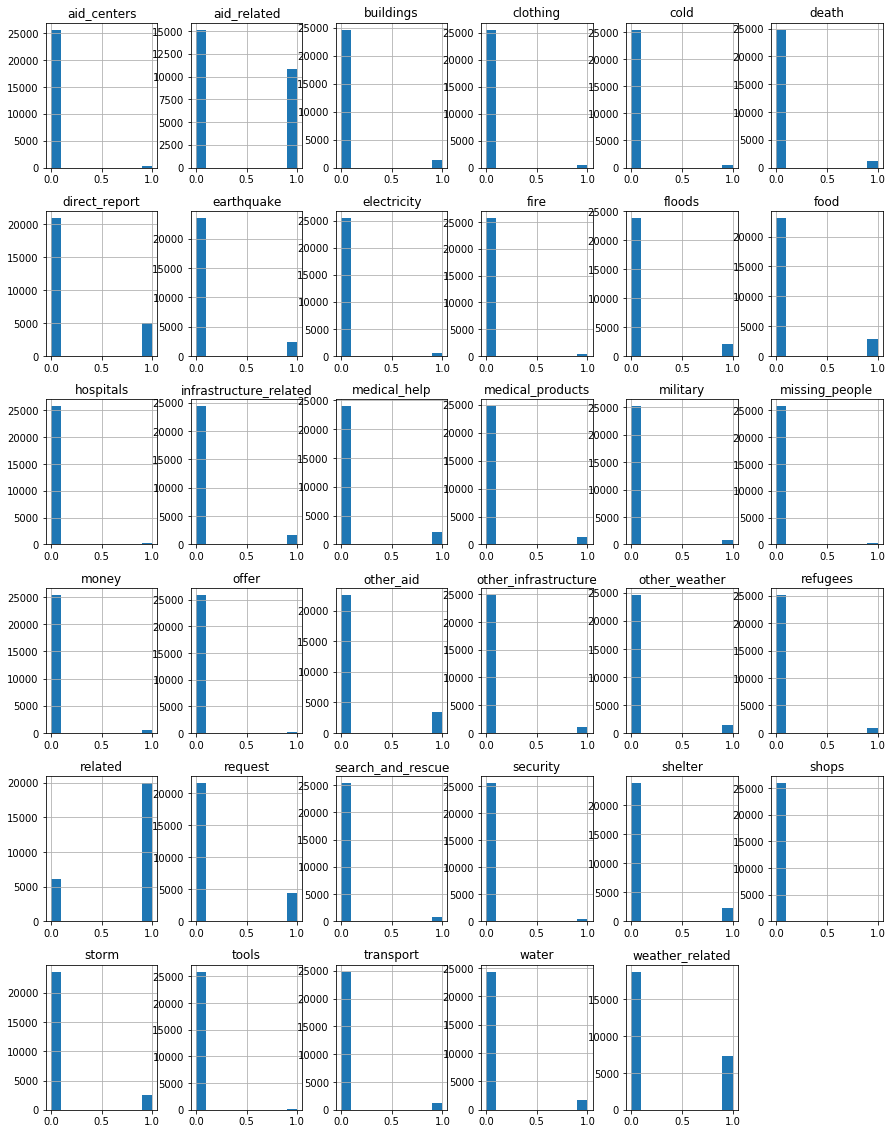

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
Y.hist(ax = ax)

### 6. Improve your model
Use grid search to find better parameters. 

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
# Define performance metric for use in grid search scoring object
def performance_metric(y_true, y_pred):
    """Calculate median F1 score for all of the output classifiers
    
    Args:
    y_true: array. Array containing actual labels.
    y_pred: array. Array containing predicted labels.
        
    Returns:
    score: float. Median F1 score for all of the output classifiers
    """
    f1_list = []
    for i in range(np.shape(y_pred)[1]):
        f1 = f1_score(np.array(y_true)[:, i], y_pred[:, i])
        f1_list.append(f1)
        
    score = np.median(f1_list)
    return score

In [14]:
parameters = {'vect__min_df': [1, 5],
              'tfidf__use_idf':[True],
              'clf__estimator__n_estimators':[10, 25], 
              'clf__estimator__min_samples_split':[5, 10]}

scorer = make_scorer(performance_metric)
cv = GridSearchCV(pipeline, param_grid = parameters, scoring = scorer, verbose = 10)

In [15]:
# Find best parameters
np.random.seed(81)
tuned_model = cv.fit(X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.14388489208633093, total=  47.7s
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.12844036697247704, total=  47.1s
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.18796992481203006, total=  47.1s
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.22, total=  43.0s
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.22033898305084748, total=  42.7s
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.17518248175182483, total=  43.3s
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.2min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.13866666666666666, total= 1.4min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  8.0min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.1134020618556701, total= 1.4min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  9.8min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.14634146341463417, total= 1.4min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 11.6min remaining:    0.0s
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5, score=0.176, total= 1.3min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5, score=0.18128654970760236, total= 1.3min
[CV] clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=5, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5, score=0.16759776536312848, total= 1.3min
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.17898832684824903, total=  44.4s
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.16422287390029328, total=  44.2s
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=1, score=0.09944751381215469, total=  44.6s
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.21649484536082475, total=  41.4s
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.180327868852459, total=  41.2s
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=10, tfidf__use_idf=True, vect__min_df=5, score=0.17094017094017094, total=  41.8s
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.14130434782608697, total= 1.3min
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.14096916299559473, total= 1.3min
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=1, score=0.09340659340659342, total= 1.4min
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5, score=0.18652849740932642, total= 1.2min
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5, score=0.16597510373443983, total= 1.2min
[CV] clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5 


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  clf__estimator__min_samples_split=10, clf__estimator__n_estimators=25, tfidf__use_idf=True, vect__min_df=5, score=0.18840579710144925, total= 1.2min


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 32.1min finished


In [16]:
# Get results of grid search
tuned_model.cv_results_

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([ 38.7435139 ,  34.81326326,  75.62336047,  65.48557488,
         35.89947271,  33.33637126,  69.39702511,  62.75144458]),
 'std_fit_time': array([ 0.30459021,  0.29856519,  0.643789  ,  0.32283779,  0.25367676,
         0.31215561,  0.53124071,  0.44500253]),
 'mean_score_time': array([  8.54736797,   8.19181267,  10.82198286,   9.94519512,
          8.4806242 ,   8.13681602,  10.88850093,  10.08357175]),
 'std_score_time': array([ 0.09143385,  0.06646674,  0.06904555,  0.09366357,  0.0928499 ,
         0.07904297,  0.07107727,  0.12895174]),
 'param_clf__estimator__min_samples_split': masked_array(data = [5 5 5 5 10 10 10 10],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_clf__estimator__n_estimators': masked_array(data = [10 10 25 25 10 10 25 25],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_tfidf__use_idf': masked_array(data = [True True Tru

In [17]:
# Best mean test score
np.max(tuned_model.cv_results_['mean_test_score'])

0.20517382160089079

In [18]:
# Parameters for best mean test score
tuned_model.best_params_

{'clf__estimator__min_samples_split': 5,
 'clf__estimator__n_estimators': 10,
 'tfidf__use_idf': True,
 'vect__min_df': 5}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [19]:

# Calculate evaluation metrics for test set
tuned_pred_test = tuned_model.predict(X_test)

eval_metrics1 = get_eval_metrics(np.array(Y_test), tuned_pred_test, col_names)

print(eval_metrics1)

                        Accuracy  Precision    Recall        F1
related                 0.809590   0.840519  0.926314  0.881333
request                 0.889350   0.767380  0.512500  0.614561
offer                   0.996465   0.000000  0.000000  0.000000
aid_related             0.754726   0.707869  0.688317  0.697956
medical_help            0.921777   0.536232  0.142582  0.225266
medical_products        0.956508   0.666667  0.236760  0.349425
search_and_rescue       0.976641   0.518519  0.091503  0.155556
security                0.980483   0.384615  0.040323  0.072993
military                0.966651   0.550000  0.147982  0.233216
water                   0.960504   0.838298  0.473558  0.605223
food                    0.942370   0.799314  0.643646  0.713083
shelter                 0.938835   0.753501  0.464594  0.574786
clothing                0.988628   0.725490  0.381443  0.500000
money                   0.979099   0.666667  0.070922  0.128205
missing_people          0.987245   0.000

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# Get summary stats for first model
eval_metrics0.describe()

,Accuracy,Precision,Recall,F1
count,35.000000,35.000000,35.000000,35.000000
mean,0.942400,0.564538,0.187315,0.241425
std,0.057651,0.333674,0.243477,0.269195
min,0.744275,0.000000,0.000000,0.000000
25%,0.931689,0.381818,0.016632,0.032458
50%,0.955586,0.733333,0.064740,0.116667
75%,0.980559,0.813056,0.324296,0.453287
max,0.996465,1.000000,0.909603,0.876941


In [21]:

# Get summary stats for tuned model
eval_metrics1.describe()

,Accuracy,Precision,Recall,F1
count,35.000000,35.000000,35.000000,35.000000
mean,0.945334,0.538518,0.255379,0.315370
std,0.055417,0.296135,0.267915,0.281042
min,0.754726,0.000000,0.000000,0.000000
25%,0.939450,0.451567,0.054060,0.096885
50%,0.960504,0.666667,0.142582,0.225266
75%,0.981405,0.747121,0.469076,0.590005
max,0.996465,0.893805,0.926314,0.881333


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [24]:
# Pickle best model
import pickle

pickle.dump(tuned_model, open('srodri10_disaster_model_v0.sav', 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.